In [1]:
from tool import *

In [2]:
import missingno as msno

## 1. DOA DB를 불러옴

In [3]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [5]:
df.head(3)

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN


<AxesSubplot:>

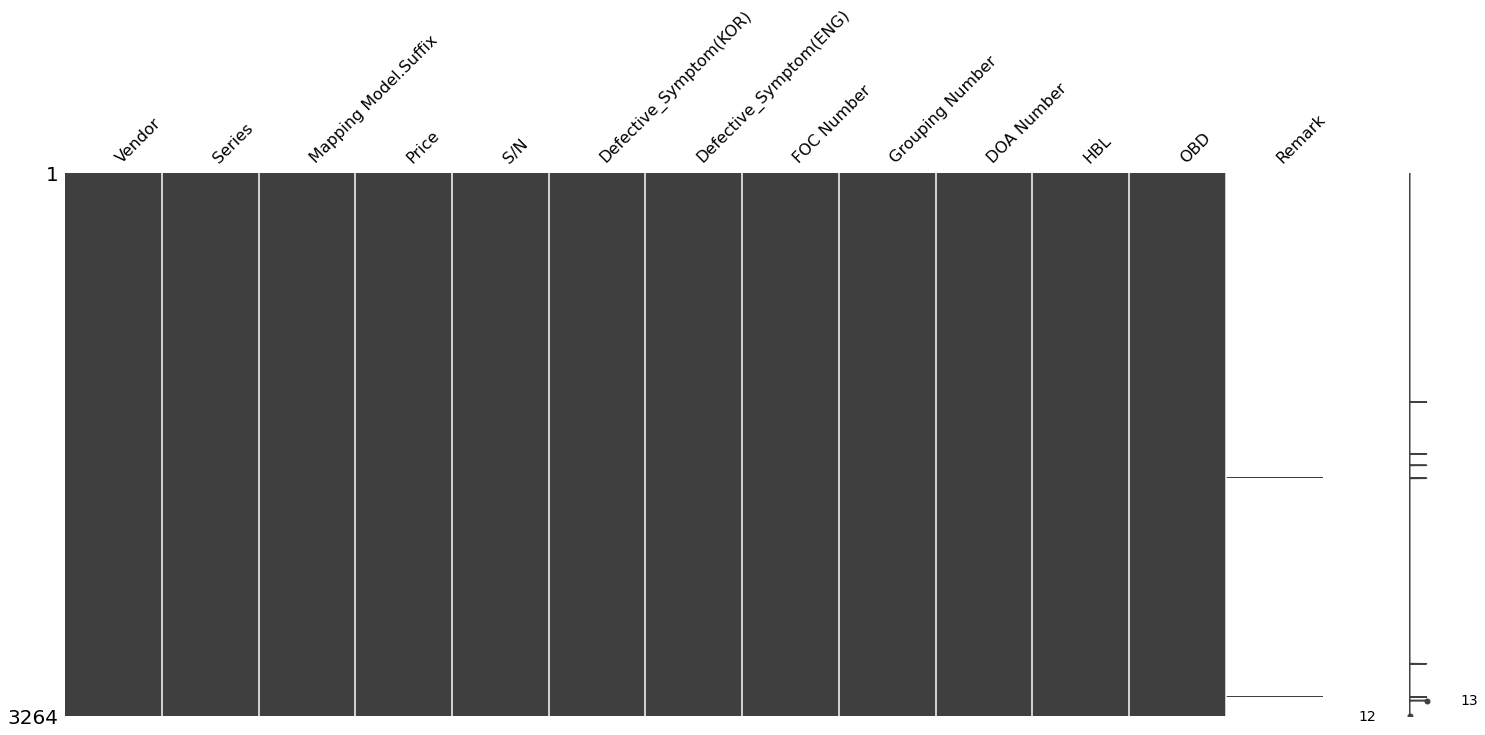

In [4]:
msno.matrix(df)

In [3]:
df.fillna('없음').pivot_table('S/N', index=['Vendor', 'DOA Number','FOC Number'], aggfunc='count')

S/N
Vendor   DOA Number     FOC Number      
Pegatron LG211006       F1000190536   35
         LG211102       F1000191443   26
         LG211201       F1000192504   63
         LG220304       F1000195153   51
         LG220510       F1000197493   27
         LG220721       F1000199890   39
         LG220818       F1000200869  562
         LG221017       F1000202530   42
         LG221108       F1000203191   45
Quanta   N5T21916H-391  F1000190204    8
         N5V21927H-391  F1000190524  312
         N5V21B08H-391  F1000191764  137
         N5V21B24H-391L F1000192308   47
         N5V21C16H-391L F1000192987  121
         N5V22112H-391L F1000193650  217
         N5V22316H-391L F1000195776  261
         N5V22513H-391L F1000197491  373
         N5V22613H-391L F1000198527   79
         N5V22719H-391L F1000199889  119
         N5V22720H-391L F1000200529  323
         N5V22721H-391L F1000200529  143
         N5V22A08H-391L F1000202340  119
         N5V22B10H-391L F1000203479   37
         N5V22C08H-391L F1000204203   78

## 2. 신규 DOA 파일을 가져와서 불량내용을 영문 번역

In [8]:
# 권혁호 주임 불량 현황 엑셀파일 불러옴
df_new = pd.read_excel(get_filename(), sheet_name='Sheet1')
df_new = df_new[['분류', '모델', 'S/N', '비고']]
df_new.columns  = ['Vendor', 'Mapping Model.Suffix', 'S/N', 'Defective_Symptom(KOR)']
df_new = df_new.dropna(how='all')
df_new = df_new[~(df_new['Vendor'] == '남경')]
df_new.groupby('Vendor')['S/N'].count() # 물류에서 관리하는 파일 기준, 업체별 불량 수량 확인

Vendor
Pegatron    52
Quanta      73
W            3
Name: S/N, dtype: int64

In [9]:
# 모델과 Vendor과 잘 mapping 되었는지 2차 확인용
df_new.insert(1, 'Series', df_new['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model))
df_new['Vendor_check'] = df_new['Series'].replace(vendor_find)
df_new.groupby('Vendor_check')['S/N'].count()

Vendor_check
Pegatron    52
Quanta      73
Wingtech     3
Name: S/N, dtype: int64

In [10]:
# S/N이 13자리로 구성되어 있는 지 확인
df_new['S/N'].str.len().value_counts()

13    128
Name: S/N, dtype: int64

In [11]:
df_new['S/N'].str.strip().str.len().value_counts()

13    128
Name: S/N, dtype: int64

In [15]:
df_new[df_new['S/N'].str.len() == 12]

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor_check
124,W,10A30Q,10A30Q-L.AQ14K,207WIBF00013,LCD 좌측 상단 어두움,10A30Q


In [12]:
df_new.head(3)

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor_check
0,Pegatron,14T30Q,14T30Q-E.A310ML,209PGBL786053,LCD 백점,Pegatron
1,Pegatron,14T30Q,14T30Q-E.A310ML,209PGCD778787,화면 이상,Pegatron
2,Pegatron,14T30Q,14T30Q-E.A310ML,209PGCD785195,LCD 백점,Pegatron


In [13]:
df_new = df_new.drop(columns='Vendor')

In [14]:
df_new.shape

(128, 5)

In [15]:
df_new = df_new.rename(columns={'Vendor_check':'Vendor'})
c1 = df_new['Vendor'].isin(['Pegatron', 'Quanta'])
df_new = df_new[c1]
df_new.shape

(125, 5)

In [16]:
df_new.groupby('Vendor')['Mapping Model.Suffix'].count()

Vendor
Pegatron    52
Quanta      73
Name: Mapping Model.Suffix, dtype: int64

In [17]:
df_new['Defective_Symptom(ENG)'] = df_new['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])

In [18]:
df_new[['Defective_Symptom(KOR)', 'Defective_Symptom(ENG)']]

,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,LCD 백점,LCD Hundred Points
1,화면 이상,over screen
2,LCD 백점,LCD Hundreds
3,Touch Pad 좌측 누름 시 이중클릭,Double-click when left-clicking on the Touch Pad
4,LCD 백점,LCD Hundred Points
...,...,...
120,A-Part & D-Part 얼룩,A-Part &amp; D-Part Stain
121,Box 불량,Box defective
122,Speaker Noise,Speaker Noise
123,Webcam 화면 상하 반전 불량,Bad inversion of the webcam screen


In [19]:
df_new.to_clipboard()

In [14]:
df_add = pd.read_clipboard()

In [15]:
df_add

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCLH574960,LCD 벌어짐,LCD easily take off from the bezel by weak for...
1,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCNL574847,LCD 벌어짐,LCD easily take off from the bezel by weak for...
2,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCPY574952,LCD 벌어짐,LCD easily take off from the bezel by weak for...
3,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCQX574932,LCD 벌어짐,LCD easily take off from the bezel by weak for...
4,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCRN574902,LCD 벌어짐,LCD easily take off from the bezel by weak for...
...,...,...,...,...,...,...
461,Quanta,16T90P,16TG90P-G.AR5DKF,203QCBD576197,SKU 변경 재작업 필요,SKU change rework required
462,Quanta,16T90P,16TG90P-G.AR5DKF,203QCZP575245,SKU 변경 재작업 필요,SKU change rework required
463,Quanta,16T90P,16TG90P-G.AR5DKF,203QCCV575195,SKU 변경 재작업 필요,SKU change rework required
464,Quanta,16T90P,16TG90P-G.AR5DKF,203QCYQ575770,SKU 변경 재작업 필요,SKU change rework required


In [16]:
df.head(1)

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN


### ODM 업체로 보낼 파일 생성

In [4]:
df_new = pd.read_excel(get_filename(), sheet_name=0)

In [11]:
df_new = df_new.drop(df_new.loc[df_new['Quanta Remark'].str.contains('DOA')].index).reset_index(drop=True)
df_new

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),Quanta Remark
0,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCAS574800,간헐적 인터넷 끊김,Intermittent Internet Loss,YES
1,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCEA574724,LCD Open/Close Noise,LCD Open/Close Noise,YES
2,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCGW574767,C-Part Scratch,C-Part Scratch,YES
3,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCGW574815,D-Part Scratch,D-Part Scratch,YES
4,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCHE566289,제품 내부 소음,product internal noise,YES
5,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCLH574672,LCD Open/Close Noise,LCD Open/Close Noise,YES
6,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCLH574720,KBD Alt Key 복원 느림,KBD Alt Key restore slow,YES
7,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCPY574616,LCD Open/Close Noise,LCD Open/Close Noise,YES
8,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCRN574638,화면 회전 안됨,Screen not rotating,YES
9,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCSF574694,LCD Open/Close Noise,LCD Open/Close Noise,YES


In [19]:
df_new = df_new.drop(columns='Quanta Remark')
df_new

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCAS574800,간헐적 인터넷 끊김,Intermittent Internet Loss
1,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCEA574724,LCD Open/Close Noise,LCD Open/Close Noise
2,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCGW574767,C-Part Scratch,C-Part Scratch
3,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCGW574815,D-Part Scratch,D-Part Scratch
4,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCHE566289,제품 내부 소음,product internal noise
5,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCLH574672,LCD Open/Close Noise,LCD Open/Close Noise
6,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCLH574720,KBD Alt Key 복원 느림,KBD Alt Key restore slow
7,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCPY574616,LCD Open/Close Noise,LCD Open/Close Noise
8,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCRN574638,화면 회전 안됨,Screen not rotating
9,Quanta,11T50Q,11TG50Q-E.AC10KN,206QCSF574694,LCD Open/Close Noise,LCD Open/Close Noise


In [33]:
today = datetime.date.today()

In [34]:
df_new.loc[df_new['Vendor'] == 'Pegatron'].to_excel(f'D:/Python result/{today.isoformat()}_Pegatron DOA.xlsx')

In [35]:
df_new.loc[df_new['Vendor'] == 'Quanta'].to_excel(f'D:/Python result/{today.isoformat()}_Quanta DOA.xlsx')

### 엑셀 DOA 발송 리스트 불러오기

In [12]:
df_new = pd.read_excel(get_filename())
df_new = df_new.rename(columns={'Defect Reason_Korean':'Defective_Symptom(KOR)', 'Defect Reason_English':'Defective_Symptom(ENG)'})
df_new['Series'] = df_new['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model)
df_new

,Vendor,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),Series
0,Quanta,11TG50Q-E.AC10KN,206QCAS574704,T/Pad Button-L 둔감,T/Pad Button-L insensitive,11T50Q
1,Quanta,11TG50Q-E.AC10KN,207QCZP562125,Power Cord 누락,Missing Power Cord,11T50Q
2,Quanta,14T90Q-G.AA79K,210QCAS557192,A/B-Part 상단 중앙 누름시 소음,Noise when pressing the center of the top of A...,14T90Q
3,Quanta,14T90Q-G.AA79K,210QCMR557211,B-Part 하단 Gap,B-Part Bottom Gap,14T90Q
4,Quanta,14T90Q-G.AA79K,210QCYQ557250,T/Pad Button Air Gap,T/Pad Button Air Gap,14T90Q
...,...,...,...,...,...,...
73,Quanta,16T90Q-G.AAFBK,211QCJZ561380,LCD 얼룩,LCD stain,16T90Q
74,Quanta,16TD90Q-G.AX70K,204QCVU564399,D-Part 누름 시 소음,Noise when pressing D-Part,16T90Q
75,Quanta,16TD90Q-G.AX70K,209QCEA558332,LCD Open/Close Noise,LCD Open/Close Noise,16T90Q
76,Quanta,16TD90Q-G.AX70K,211QCUK561542,힌지부 틀어짐(단차),Hinge misalignment (step difference),16T90Q


<AxesSubplot:>

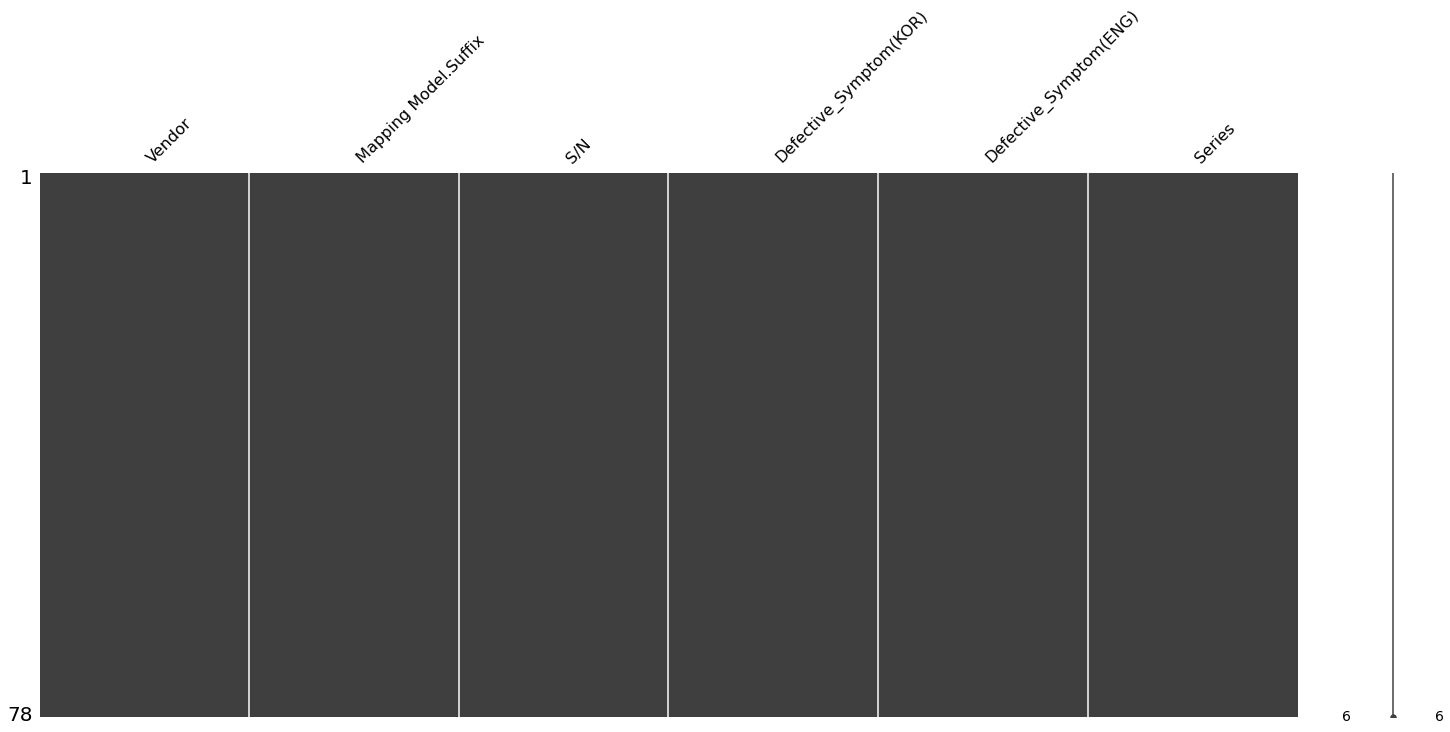

In [14]:
msno.matrix(df_new)

In [8]:
df_new = pd.read_excel(get_filename(), sheet_name='DOA list')
df_new

,Unnamed: 0,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),Remark
0,0,Pegatron,13U70Q,13U70Q-G.AR5SK,205PGAG722056,LCD 우측 상단 쳐짐,Upper right corner of the LCD is sagging,DOA
1,1,Pegatron,13U70Q,13UD70Q-G.AX50K,111PGUH617286,"평탄도 불량, B-Part Scratch","Poor flatness, B-Part scratch",DOA
2,2,Pegatron,14T30Q,14T30Q-E.A310ML,211PGCD796803,Box 불량,Box bad,DOA
3,3,Pegatron,14T30Q,14TN30Q-E.AO14KN,208PGZU771965,Alt Key Scratch,Alt Key Scratch,DOA
4,4,Pegatron,14T30Q,14TN30Q-E.AO14KN,209PGAG775344,Box 불량,Box bad,DOA
5,5,Pegatron,14T30Q,14TN30Q-E.AO14KN,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,DOA
6,6,Pegatron,14T30Q,14TN30Q-E.AO14KN,212PGDX802266,LCD 가로줄,LCD horizontal line,DOA
7,7,Pegatron,14T30Q,14TN30Q-E.AO14KN,212PGZU801781,LCD 백점,LCD white spot,DOA
8,8,Pegatron,14T30Q,14TW30Q-E.AO14ML,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),DOA
9,9,Pegatron,17U70Q,17U70Q-P.AR50K,206PGLQ735640,Box 불량,Box bad,DOA


In [12]:
df_new

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),Remark
0,Pegatron,13U70Q,13U70Q-G.AR5SK,205PGAG722056,LCD 우측 상단 쳐짐,Upper right corner of the LCD is sagging,DOA
1,Pegatron,13U70Q,13UD70Q-G.AX50K,111PGUH617286,"평탄도 불량, B-Part Scratch","Poor flatness, B-Part scratch",DOA
2,Pegatron,14T30Q,14T30Q-E.A310ML,211PGCD796803,Box 불량,Box bad,DOA
3,Pegatron,14T30Q,14TN30Q-E.AO14KN,208PGZU771965,Alt Key Scratch,Alt Key Scratch,DOA
4,Pegatron,14T30Q,14TN30Q-E.AO14KN,209PGAG775344,Box 불량,Box bad,DOA
5,Pegatron,14T30Q,14TN30Q-E.AO14KN,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,DOA
6,Pegatron,14T30Q,14TN30Q-E.AO14KN,212PGDX802266,LCD 가로줄,LCD horizontal line,DOA
7,Pegatron,14T30Q,14TN30Q-E.AO14KN,212PGZU801781,LCD 백점,LCD white spot,DOA
8,Pegatron,14T30Q,14TW30Q-E.AO14ML,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),DOA
9,Pegatron,17U70Q,17U70Q-P.AR50K,206PGLQ735640,Box 불량,Box bad,DOA


## DB에 추가

In [14]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [15]:
df.shape

(3264, 13)

In [16]:
df = pd.concat([df, df_new]).reset_index(drop=True)
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3269,Pegatron,14T30Q,14TN30Q-E.AO14KN,NaN,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,NaN,NaN,NaN,NaN,NaT,DOA
3270,Pegatron,14T30Q,14TN30Q-E.AO14KN,NaN,212PGDX802266,LCD 가로줄,LCD horizontal line,NaN,NaN,NaN,NaN,NaT,DOA
3271,Pegatron,14T30Q,14TN30Q-E.AO14KN,NaN,212PGZU801781,LCD 백점,LCD white spot,NaN,NaN,NaN,NaN,NaT,DOA
3272,Pegatron,14T30Q,14TW30Q-E.AO14ML,NaN,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),NaN,NaN,NaN,NaN,NaT,DOA


In [17]:
df.shape

(3274, 13)

In [19]:
df.loc[df['Price'].isnull(), 'DOA Number'] = 'LG230308'

In [ ]:
# Futher analysis needed set marking
snlist = ['203QCRN577110']

In [22]:
df.fillna('N/A').groupby(['Vendor', 'DOA Number', 'OBD','HBL'])['S/N'].count()

Vendor    DOA Number      OBD                  HBL           
Pegatron  LG211006        2021-10-12 00:00:00  SMCIA216103        35
          LG211102        2021-11-09 00:00:00  SMCIA216793        26
          LG211201        2021-12-09 00:00:00  SMCIA217762        63
          LG220304        2022-03-17 00:00:00  SEL-0052 9817      51
          LG220510        2022-05-25 00:00:00  SEL-0053 5903      27
          LG220721        2022-08-01 00:00:00  SEL-0054 0419      39
          LG220818        2022-09-01 00:00:00  988-40865871      562
          LG221017        2022-10-23 00:00:00  SEL-0054 5900      42
          LG221108        2022-11-13 00:00:00  5501 1591 8253     45
Quanta    N5T21916H-391   2021-10-07 00:00:00  SMCIA215936         8
          N5V21927H-391   2021-10-12 00:00:00  SMCIA216102       312
          N5V21B08H-391   2021-11-18 00:00:00  SMCIA217109       137
          N5V21B24H-391L  2021-12-02 00:00:00  SMCIA217546        47
          N5V21C16H-391L  2021-12-23 00:0

## DOA/FOC/CC grouping No update

In [37]:
foc = 'F1000207121'
cc_group = 'CPCZ2303140001'

In [38]:
c1 =  df['FOC Number'].isnull()
c2 = df['DOA Number'] == 'LG230308'
df.loc[c1 & c2, ['FOC Number', 'Grouping Number']] = (foc, cc_group)

In [39]:
df[c1]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3264,Pegatron,13U70Q,13U70Q-G.AR5SK,510.15,205PGAG722056,LCD 우측 상단 쳐짐,Upper right corner of the LCD is sagging,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3265,Pegatron,13U70Q,13UD70Q-G.AX50K,509.44,111PGUH617286,"평탄도 불량, B-Part Scratch","Poor flatness, B-Part scratch",F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3266,Pegatron,14T30Q,14T30Q-E.A310ML,335.84,211PGCD796803,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3267,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,208PGZU771965,Alt Key Scratch,Alt Key Scratch,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3268,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGAG775344,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3269,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3270,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGDX802266,LCD 가로줄,LCD horizontal line,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3271,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGZU801781,LCD 백점,LCD white spot,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3272,Pegatron,14T30Q,14TW30Q-E.AO14ML,331.54,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3273,Pegatron,17U70Q,17U70Q-P.AR50K,843.48,206PGLQ735640,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA


In [41]:
c1 = (df['Vendor'] == vendor)
c2 = (df['RMA Number'] == rma)

In [58]:
# 변경할 데이타 확인
df.loc[c1&c2, ['RMA Number', 'FOC Number', 'Grouping Number']]

,RMA Number,FOC Number,Grouping Number
2943,N5V22A08H-391L,NaN,NaN
2944,N5V22A08H-391L,NaN,NaN
2945,N5V22A08H-391L,NaN,NaN
2946,N5V22A08H-391L,NaN,NaN
2947,N5V22A08H-391L,NaN,NaN
...,...,...,...
3057,N5V22A08H-391L,NaN,NaN
3058,N5V22A08H-391L,NaN,NaN
3059,N5V22A08H-391L,NaN,NaN
3060,N5V22A08H-391L,NaN,NaN


In [60]:
#데이타 수정
df.loc[c1&c2, ['FOC Number', 'Grouping Number']] = [foc, cc_group]

In [62]:
# 변경되었는지 확인
df.loc[c1&c2, ['RMA Number', 'FOC Number', 'Grouping Number']]

,RMA Number,FOC Number,Grouping Number
2943,N5V22A08H-391L,F1000202340,CPCZ2210170001
2944,N5V22A08H-391L,F1000202340,CPCZ2210170001
2945,N5V22A08H-391L,F1000202340,CPCZ2210170001
2946,N5V22A08H-391L,F1000202340,CPCZ2210170001
2947,N5V22A08H-391L,F1000202340,CPCZ2210170001
...,...,...,...
3057,N5V22A08H-391L,F1000202340,CPCZ2210170001
3058,N5V22A08H-391L,F1000202340,CPCZ2210170001
3059,N5V22A08H-391L,F1000202340,CPCZ2210170001
3060,N5V22A08H-391L,F1000202340,CPCZ2210170001


## 3. 선적 정보 update

In [5]:
df[df['Vendor'] == 'Quanta']['HBL'].unique()

array(['SMCIA215936', 'SMCIA216102', 'SMCIA217109', 'SMCIA217546',
       'SMCIA218236', 'SMCIA220491', 'SEL-0053 2825', 'SEL-0053 4511',
       'SEL-0053 8703', 'SEL-0054 0418', '112-64178870', 'SEL-0054 5657',
       '550115928366', 'SEL-0055 2553'], dtype=object)

In [6]:
BL = 'SEL-0055 9015'
obd = datetime.datetime(2023, 3, 18)

In [9]:
c1 = df['Vendor'] == 'Pegatron'
c2 = df['HBL'].isnull()
df[c1 & c2]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3264,Pegatron,13U70Q,13U70Q-G.AR5SK,510.15,205PGAG722056,LCD 우측 상단 쳐짐,Upper right corner of the LCD is sagging,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3265,Pegatron,13U70Q,13UD70Q-G.AX50K,509.44,111PGUH617286,"평탄도 불량, B-Part Scratch","Poor flatness, B-Part scratch",F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3266,Pegatron,14T30Q,14T30Q-E.A310ML,335.84,211PGCD796803,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3267,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,208PGZU771965,Alt Key Scratch,Alt Key Scratch,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3268,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGAG775344,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3269,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3270,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGDX802266,LCD 가로줄,LCD horizontal line,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3271,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGZU801781,LCD 백점,LCD white spot,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3272,Pegatron,14T30Q,14TW30Q-E.AO14ML,331.54,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3273,Pegatron,17U70Q,17U70Q-P.AR50K,843.48,206PGLQ735640,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA


In [14]:
df.loc[c1 & c2, ['HBL', 'OBD']] = (BL, obd)

,HBL,OBD
3264,SEL-0055 9015,2023-03-18
3265,SEL-0055 9015,2023-03-18
3266,SEL-0055 9015,2023-03-18
3267,SEL-0055 9015,2023-03-18
3268,SEL-0055 9015,2023-03-18
3269,SEL-0055 9015,2023-03-18
3270,SEL-0055 9015,2023-03-18
3271,SEL-0055 9015,2023-03-18
3272,SEL-0055 9015,2023-03-18
3273,SEL-0055 9015,2023-03-18


In [15]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## 최종 Packing 완료된 기준의 DOA 리스트를 불러옴

In [7]:
df = pd.read_excel(get_filename(), sheet_name='Sheet1')
df

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,Pegatron,13U70Q,13U70Q-G.AR36K,202PGZU667181,T/Pad Button Noise,T/Pad Button Noise
1,Pegatron,13U70Q,13U70Q-G.AR5SK,202PGJK667052,System Fan Noise,System Fan Noise
2,Pegatron,13U70Q,13U70Q-G.AR5SK,205PGAG722056,LCD 좌우 틀어짐,LCD twisted left and right
3,Pegatron,13U70Q,13U70Q-G.AR5SK,205PGAG722080,LCD 좌우 틀어짐,LCD twisted left and right
4,Pegatron,14T30Q,14TG30Q-E.A710KN,207PGPM762184,T/Pad 상단부 유동,Flow at the top of the T/Pad
5,Pegatron,14T30Q,14TN30Q-E.AO14KN,207PGGE750623,LCD 얼룩,LCD stain
6,Pegatron,17U70Q,17U70Q-P.AA70K,206PGNB744959,LCD Open/Close Noise,LCD Open/Close Noise
7,Pegatron,17U70Q,17U70Q-P.AA70K,206PGWR744961,LCD Open/Close Noise,LCD Open/Close Noise
8,Pegatron,17U70Q,17U70Q-P.AR50K,206PGLQ735640,D-Part Vent Hole 불량(Silver)\n*PM : Black*,D-Part Vent Hole Bad (Silver)\n*PM : Black*
9,Pegatron,17U70Q,17U70Q-P.AR50K,206PGQN735612,Touch Pad 좌/우 누름 시 둔감,Touch pad dullness when pressed left/right


In [8]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    doa = pickle.load(f)

In [10]:
doa.groupby(['Vendor', 'OBD'],dropna=False)['S/N'].count()

Vendor    OBD                
Pegatron  2021-10-12 00:00:00     35
          2021-11-09 00:00:00     26
          2021-12-09 00:00:00     63
          2022-03-17 00:00:00     51
          2022-05-25 00:00:00     27
          2022-08-01 00:00:00     39
          2022-09-01             562
Quanta    2021-10-07 00:00:00      8
          2021-10-12 00:00:00    312
          2021-11-18 00:00:00    137
          2021-12-02 00:00:00     47
          2021-12-23 00:00:00    121
          2022-01-20 00:00:00    217
          2022-04-14 00:00:00    261
          2022-05-25 00:00:00    373
          2022-07-03 00:00:00     79
          2022-08-01 00:00:00    119
          2022-08-26 00:00:00    466
          2022-10-20             119
Name: S/N, dtype: int64

In [12]:
df = pd.concat([pd.DataFrame(columns=doa.columns), df])
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Pegatron,13U70Q,13U70Q-G.AR36K,NaN,202PGZU667181,T/Pad Button Noise,T/Pad Button Noise,NaN,NaN,NaN,NaN,NaN,NaN
1,Pegatron,13U70Q,13U70Q-G.AR5SK,NaN,202PGJK667052,System Fan Noise,System Fan Noise,NaN,NaN,NaN,NaN,NaN,NaN
2,Pegatron,13U70Q,13U70Q-G.AR5SK,NaN,205PGAG722056,LCD 좌우 틀어짐,LCD twisted left and right,NaN,NaN,NaN,NaN,NaN,NaN
3,Pegatron,13U70Q,13U70Q-G.AR5SK,NaN,205PGAG722080,LCD 좌우 틀어짐,LCD twisted left and right,NaN,NaN,NaN,NaN,NaN,NaN
4,Pegatron,14T30Q,14TG30Q-E.A710KN,NaN,207PGPM762184,T/Pad 상단부 유동,Flow at the top of the T/Pad,NaN,NaN,NaN,NaN,NaN,NaN
5,Pegatron,14T30Q,14TN30Q-E.AO14KN,NaN,207PGGE750623,LCD 얼룩,LCD stain,NaN,NaN,NaN,NaN,NaN,NaN
6,Pegatron,17U70Q,17U70Q-P.AA70K,NaN,206PGNB744959,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,NaN,NaN,NaN,NaN
7,Pegatron,17U70Q,17U70Q-P.AA70K,NaN,206PGWR744961,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,NaN,NaN,NaN,NaN
8,Pegatron,17U70Q,17U70Q-P.AR50K,NaN,206PGLQ735640,D-Part Vent Hole 불량(Silver)\n*PM : Black*,D-Part Vent Hole Bad (Silver)\n*PM : Black*,NaN,NaN,NaN,NaN,NaN,NaN
9,Pegatron,17U70Q,17U70Q-P.AR50K,NaN,206PGQN735612,Touch Pad 좌/우 누름 시 둔감,Touch pad dullness when pressed left/right,NaN,NaN,NaN,NaN,NaN,NaN


## 4. 최신 사입가로 업데이트

In [21]:
df[df['Price'].isnull()].groupby('Vendor')['S/N'].count() # 가격이 없는 데이타 확인

Vendor
Pegatron    10
Name: S/N, dtype: int64

In [22]:
vendor = 'Pegatron' # 최신 사입가를 받아올 업체 선택
with open(f'D:/Data/{vendor} PO DB.bin', 'rb') as f: # Quanta PO DB를 불러옴
    up_check = pickle.load(f)

lt_date = up_check.groupby('Mapping Model.Suffix')['Issued Date'].max() # PO DB에서 모델명별 최신 PO일자 정보를 만듬
up_check = up_check.set_index(['Mapping Model.Suffix', 'Issued Date']) # PO DB 조회하기 위해 모델명, PO발행일을 인덱스로 설정
lt_price = pd.Series() # 빈 시리즈만들고, Lopp돌며 모델별 최신일자의 사입가를 빈 시리즈에 작성

for i in lt_date.index:
    lt_price.loc[i] = up_check.loc[(i, lt_date.loc[i]), 'Unit Price'].max()
lt_price.name = 'Latest Unit Price'
lt_price

C:\Users\paul76.lee\AppData\Local\Temp/ipykernel_16080/1805528706.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lt_price = pd.Series() # 빈 시리즈만들고, Lopp돌며 모델별 최신일자의 사입가를 빈 시리즈에 작성
C:\Python\Python39\lib\site-packages\pandas\core\indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


13U50N-G.AR56K    423.18
13U580-G.AA50K    406.82
13U580-G.AR30K    338.82
13U580-L.AR10K    280.82
13U580-L.AR1EK    271.82
                   ...  
CL600W-AD.AKRQ    182.54
CL600W-AP.AEUQ    198.05
CL600W-AP.AKRQ    182.55
CL600W-AQ.AEUQ    190.40
CL600W-AQ.AKRQ    174.90
Name: Latest Unit Price, Length: 241, dtype: float64

In [23]:
df.loc[df['Price'].isnull(), 'Price'] = df.loc[df['Price'].isnull(), 'Mapping Model.Suffix'].map(lt_price) # 가격이 없는 행에 최신가격 업데이트

In [24]:
df[df['Price'].isnull()]['Mapping Model.Suffix'].str.len()

Series([], Name: Mapping Model.Suffix, dtype: int64)

In [25]:
df[df['DOA Number']=='LG230308'].to_clipboard()

### 나봉훈 기정님 Packing 정보 변환

In [26]:
packing = pd.read_clipboard() # 나봉훈 기정님 공유한 packing 정보 복사하여 읽어오기

new_list = []
for name in packing.columns:
    if '\xa0' in name:
        new_list.append(name.replace('\xa0', ''))
    else:
        new_list.append(name)
packing.columns = new_list

packing = packing.rename(columns={'수량':'Pallet', '가로(cm)':'Width(cm)', '세로(cm)':'Depth(cm)',
                        '높이(cm)':'Height(cm)', '무게(kg)':'Gross Weight(Kg)', '포장단위(EA)':'Carton Qty'})
packing['Width(m)'] = packing['Width(cm)'] / 100
packing['Depth(m)'] = packing['Depth(cm)'] / 100
packing['Height(m)'] = packing['Height(cm)'] / 100
packing['Net Weight(Kg)'] = packing['Gross Weight(Kg)'] - 10
packing['CBM'] = packing['Width(m)'] * packing['Depth(m)'] * packing['Height(m)']
packing.to_clipboard(index=False)
packing

,Pallet,Width(cm),Depth(cm),Height(cm),Gross Weight(Kg),Carton Qty,Width(m),Depth(m),Height(m),Net Weight(Kg),CBM
0,(1) 10 EA,100,70,47,36,1*10=10ea,1.0,0.7,0.47,26,0.329


In [27]:
packing.to_clipboard()

In [74]:
df.loc[df['S/N'] == '209QCVU558607', 'Remark' ] = 'Need further analysis by Quanta'

In [30]:
df[df['RMA Number'] == 'LG221108'].to_excel('D:/Pegatron/221109_Pegatron New DOA_45 pcs.xlsx')

In [32]:
df.pivot_table('S/N', index=['Vendor', 'FOC Number','OBD'], aggfunc='count')

C:\Python\Python39\lib\site-packages\pandas\core\algorithms.py:1799: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  sorter = values.argsort()


S/N
Vendor   FOC Number  OBD                     
Pegatron F1000190536 2021-10-12 00:00:00   35
         F1000191443 2021-11-09 00:00:00   26
         F1000192504 2021-12-09 00:00:00   63
         F1000195153 2022-03-17 00:00:00   51
         F1000197493 2022-05-25 00:00:00   27
         F1000199890 2022-08-01 00:00:00   39
         F1000200869 2022-09-01           562
         F1000202530 2022-10-23            42
Quanta   F1000190204 2021-10-07 00:00:00    8
         F1000190524 2021-10-12 00:00:00  312
         F1000191764 2021-11-18 00:00:00  137
         F1000192308 2021-12-02 00:00:00   47
         F1000192987 2021-12-23 00:00:00  121
         F1000193650 2022-01-20 00:00:00  217
         F1000195776 2022-04-14 00:00:00  261
         F1000197491 2022-05-25 00:00:00  373
         F1000198527 2022-07-03 00:00:00   79
         F1000199889 2022-08-01 00:00:00  119
         F1000200529 2022-08-26 00:00:00  466
         F1000202340 2022-10-20           119

In [22]:
df.columns

Index(['Vendor', 'Series', 'Mapping Model.Suffix', 'Price', 'S/N',
       'Defective_Symptom(KOR)', 'Defective_Symptom(ENG)', 'FOC Number',
       'Grouping Number', 'RMA Number', 'HBL', 'OBD', 'Remark'],
      dtype='object')

In [37]:
foc = 'F1000203191'
group = 'CPCZ2211090008'

In [39]:
df.loc[df['RMA Number'] == 'LG221108', ('FOC Number', 'Grouping Number')] = [foc, group]

In [24]:
df[['FOC Number', 'Grouping Number']] = ['F1000202530', 'CPCZ2210200001']

In [27]:
doa = pd.concat([doa, df])
doa = doa.reset_index(drop=True)
doa

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,Pegatron,17U70Q,17UD70Q-P.AX70K,925.05,207PGGE761879,LCD 세로줄,LCD vertical line,F1000202530,CPCZ2210200001,LG221017,NaN,NaN,NaN
3100,Pegatron,17U70Q,17UD70Q-P.AX70K,925.05,207PGKW761909,C-Part 찍힘,C-Part stamped,F1000202530,CPCZ2210200001,LG221017,NaN,NaN,NaN
3101,Pegatron,17U70Q,17UD70Q-P.AX70K,925.05,207PGLQ761952,LCD 백점 (좌측 하단),LCD white point (bottom left),F1000202530,CPCZ2210200001,LG221017,NaN,NaN,NaN
3102,Pegatron,17U70Q,17UD70Q-P.AX70K,925.05,207PGUH761934,LCD 백점 (좌측 하단),LCD white point (bottom left),F1000202530,CPCZ2210200001,LG221017,NaN,NaN,NaN


In [66]:
df.groupby(['Vendor', 'OBD', 'FOC Number', 'RMA Number'], dropna=False)['S/N'].count()

C:\Python\Python39\lib\site-packages\pandas\core\algorithms.py:1799: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  sorter = values.argsort()


Vendor    OBD                  FOC Number   RMA Number    
Pegatron  2021-10-12 00:00:00  F1000190536  LG211006           35
          2021-11-09 00:00:00  F1000191443  LG211102           26
          2021-12-09 00:00:00  F1000192504  LG211201           63
          2022-03-17 00:00:00  F1000195153  LG220304           51
          2022-05-25 00:00:00  F1000197493  LG220510           27
          2022-08-01 00:00:00  F1000199890  LG220721           39
          2022-09-01           F1000200869  LG220818          562
Quanta    2021-10-07 00:00:00  F1000190204  N5T21916H-391       8
          2021-10-12 00:00:00  F1000190524  N5V21927H-391     312
          2021-11-18 00:00:00  F1000191764  N5V21B08H-391     137
          2021-12-02 00:00:00  F1000192308  N5V21B24H-391L     47
          2021-12-23 00:00:00  F1000192987  N5V21C16H-391L    121
          2022-01-20 00:00:00  F1000193650  N5V22112H-391L    217
          2022-04-14 00:00:00  F1000195776  N5V22316H-391L    261
          2022-05

In [19]:
df_invoice = df.pivot_table('S/N', index=['Mapping Model.Suffix', 'Price'], aggfunc='count').reset_index()
# df_invoice['Amt'] = df['Price'] * df['S/N']
df_invoice['Amt'] = df_invoice['Price'] * df_invoice['S/N']
df_invoice.set_index(['Mapping Model.Suffix', 'Price']).to_excel('D:Python result/invoice.xlsx')

## 5. 신규 DOA 데이타를 기존 DB에 업데이트

### DOA 세트 추가 발생시 DB에 추가

In [10]:
df_add = pd.read_excel(get_filename(), sheet_name=1)
df_add

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCAS574800,간헐적 인터넷 끊김,Intermittent Internet Loss,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
1,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCEA574724,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
2,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCGW574767,C-Part Scratch,C-Part Scratch,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCGW574815,D-Part Scratch,D-Part Scratch,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
4,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCHE566289,제품 내부 소음,product internal noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
5,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCLH574672,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
6,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCLH574720,KBD Alt Key 복원 느림,KBD Alt Key restore slow,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
7,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCPY574616,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
8,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCRN574638,화면 회전 안됨,Screen not rotating,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
9,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCSF574694,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN


In [19]:
rma_num = 'N5V22B10H-391L'

df = pd.concat([df, df_add[~df_add['S/N'].isin(df[df['RMA Number'] == rma_num]['S/N'])]]).reset_index(drop=True)
df


,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,Quanta,16T90P,16TG90P-G.AR5DKN,NaN,209QCMR558547,D-Part 소음 (우측 Touch시 삐걱소음),D-Part noise (squeaking noise when right touch),NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3182,Quanta,16T90P,16TG90P-G.AR5DKN,NaN,209QCNL558647,Open / Close 소음,Open / Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3183,Quanta,15U50Q,15UD50Q-G.AX50K,NaN,210QCFT561371,KBD Space Bar Noise 불량,KBD Space Bar Noise defect,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3184,Quanta,15U50Q,15UD50Q-G.AX50K,NaN,210QCFT561251,KBD Space Bar Noise 불량,KBD Space Bar Noise defect,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN


In [30]:
df[df['RMA Number']==rma_num].to_excel('D:/Python result/221116_Quanta new DOA 37 pcs.xlsx')

In [42]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

In [43]:
# 최종 결과를 DB back up에도 저장
with open('D:/Data/DB backup/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)